In [ ]:
!pip install seaborn scikit-learn imbalanced-learn nltk


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import time
import tracemalloc


In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Load the Kaggle dataset
df = pd.read_csv('/content/twitter_training.csv')
df.columns = ['tweet id', 'entity', 'sentiment', 'Tweet content']

In [ ]:
# Filter out tweets with 'irrelevant' sentiment labels
valid_sentiments = ['Positive', 'Negative', 'Neutral']
df = df[df['sentiment'].isin(valid_sentiments)]


In [ ]:
# Preprocessing function
lemmatizer = WordNetLemmatizer()

def clean_tweet(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [
        lemmatizer.lemmatize(word) for word in words if word not in stop_words
    ]
    return ' '.join(filtered_words)


In [ ]:
# Apply preprocessing
df['cleaned_text'] = df['Tweet content'].apply(clean_tweet)


In [ ]:
# Encode labels
label_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': 2}
df['label'] = df['sentiment'].map(label_mapping)


In [ ]:
# Split data into features and labels
X = df['cleaned_text']
y = df['label']

# Apply train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1, 2), min_df=3)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)


In [ ]:
# Start monitoring
start_time = time.time()
tracemalloc.start()

# Train the Logistic Regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=300, class_weight='balanced')
model.fit(X_train_tfidf_resampled, y_train_resampled)

# Stop monitoring
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
print(f"Training Runtime: {end_time - start_time:.2f} seconds")
print(f"Training Memory Usage: {current / 1024 ** 2:.2f} MB")
print(f"Training Peak Memory Usage: {peak / 1024 ** 2:.2f} MB")
tracemalloc.stop()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Runtime: 5.07 seconds
Training Memory Usage: 1.88 MB
Training Peak Memory Usage: 12.15 MB


In [ ]:
# Start monitoring
start_time = time.time()
tracemalloc.start()

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Stop monitoring
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
print(f"Testing Runtime: {end_time - start_time:.2f} seconds")
print(f"Testing Memory Usage: {current / 1024 ** 2:.2f} MB")
print(f"Testing Peak Memory Usage: {peak / 1024 ** 2:.2f} MB")
tracemalloc.stop()

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))


Testing Runtime: 0.00 seconds
Testing Memory Usage: 0.10 MB
Testing Peak Memory Usage: 0.63 MB
Classification Report:
               precision    recall  f1-score   support

           0     0.6967    0.7477    0.7213      3678
           1     0.7885    0.7657    0.7769      4169
           2     0.8154    0.7885    0.8017      4492

    accuracy                         0.7686     12339
   macro avg     0.7669    0.7673    0.7667     12339
weighted avg     0.7709    0.7686    0.7694     12339

Confusion Matrix:
 [[2750  490  438]
 [ 613 3192  364]
 [ 584  366 3542]]
Accuracy Score: 0.7686198233244185
F1 Score: 0.7693747402578233


In [ ]:
# Start monitoring
start_time = time.time()
tracemalloc.start()

# Cross-validation
scores = cross_val_score(model, X_train_tfidf_resampled, y_train_resampled, cv=5, scoring='accuracy')
print("Cross-validation Accuracy:", scores.mean())

# Stop monitoring
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
print(f"Cross validation Runtime: {end_time - start_time:.2f} seconds")
print(f"Cross validation Memory Usage: {current / 1024 ** 2:.2f} MB")
print(f"Cross validation Peak Memory Usage: {peak / 1024 ** 2:.2f} MB")
tracemalloc.stop()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Cross-validation Accuracy: 0.7768790397045244
Cross validation Runtime: 28.36 seconds
Cross validation Memory Usage: 32.10 MB
Cross validation Peak Memory Usage: 44.31 MB


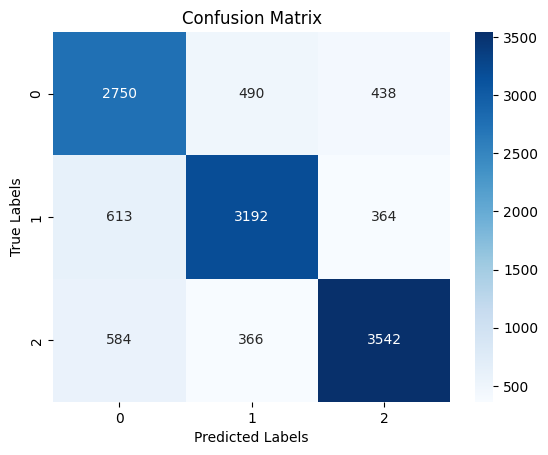

In [ ]:
# Visualize the Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
